## Imports

In [5]:
import os,sys
os.environ["JAX_PLATFORMS"] = "cpu"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import git
from ml_collections import ConfigDict

git_root = !git rev-parse --show-toplevel
sys.path.append(git_root[0])

### suppress abseil warnings 
from absl import logging

# Set ORBAX logging level to FATAL to avoid excessive output
logging.set_verbosity(logging.FATAL)

from differential_geometry import diffgeo, vdiffgeo
from general_relativity import schwarzschild_metric_spherical, schwarzschild_metric_kerr_schild, schwarzschild_metric_eddington_finkelstein

# load the utils functions to get the model and parameters from disk  
from einstein_fields.utils.utils_train import (get_model_and_params_checkpoint, load_config, make_model) 

jnp.set_printoptions(precision=2)

## Schwarzschild metric

#### 1. Defining the metric

You can either define your own metric function or use one of the classic GR solutions present in the gr_problems folder.

Lets start and create our own metric function, for example the Minkowski metric in spherical coordinates $(t, r, \theta, \phi)$:
$$g_{\mu\nu} = \begin{pmatrix}
-1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & r^2 & 0 \\
0 & 0 & 0 & r^2\sin^2\theta
\end{pmatrix}$$

In [2]:
def metric_fn(coords):
    # Unpacking coords argument, which is just a jnp.array([t, r, theta, phi])
    t, r, theta, phi = coords
    # As you can see, this metric doesn't depend on t or phi
    return jnp.diag(jnp.array([-1, 1, r**2, r**2 * jnp.sin(theta)**2]))

Let's evaluate it at the point $(0, 3, \frac{\pi}{2}, 0)$

In [3]:
print(metric_fn(jnp.array([0, 3, jnp.pi / 2, 0])))

[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  9.  0.]
 [ 0.  0.  0.  9.]]


Or we can use an existing metric, such as the Schwarzschild metric:
$$g_{\mu\nu} = \begin{pmatrix}
-(1 - \frac{2GM}{r}) & 0 & 0 & 0 \\
0 & \frac{1}{1 - \frac{2GM}{r}} & 0 & 0 \\
0 & 0 & r^2 & 0 \\
0 & 0 & 0 & r^2\sin^2\theta
\end{pmatrix}$$
The metric can be simplified even more because we will work only in units of $G=M=c=1$.

In [11]:
# See how the metric function is wrapping the original function in a lambda. 
# This is a crucial point and its the most important thing to get used to.
# As you can look at the schwarzschild_metric_spherical function, it has extra
# arguments, which are constants like the mass M. With a lambda, we can isolate
# only the coordinates, which is all we need to easy the process of differentiating,
# vmapping or jitting the function.
schwarzschild_metric = lambda coords: schwarzschild_metric_spherical(coords, M=1.0)

Let's evaluate the Schwarzschild metric at the same point

In [5]:
print(schwarzschild_metric(jnp.array([0, 3, jnp.pi / 2, 0])))

[[-0.33  0.    0.    0.  ]
 [ 0.    3.    0.    0.  ]
 [ 0.    0.    9.    0.  ]
 [ 0.    0.    0.    9.  ]]


#### 2. Differential geometry (Christoffel symbols, Riemann tensor, Ricci tensor, Rici scalar)

In [6]:
# Instantiate the differential geometry object with the schwarzschild metric function
# This will allow us to compute various geometric quantities like Christoffel symbols,
# Riemann curvature tensor, etc.
schwarzschild_geo = diffgeo(metric=schwarzschild_metric)

coords = jnp.array([0, 3, jnp.pi / 2, 0])

christoffel_symbols = schwarzschild_geo.christoffel_symbols(coords)
riemann_tensor = schwarzschild_geo.riemann_tensor(coords)
ricci_tensor = schwarzschild_geo.ricci_tensor(coords)
ricci_scalar = schwarzschild_geo.ricci_scalar(coords)

Christoffel symbols $\Gamma^{i}_{jk}$ is of shape (4, 4, 4) and we can compare for example the second (4, 4) matrix $\Gamma^{1}_{jk}$ with the analytic Christoffel symbols. They agree up to float precision around 1e-7 (float32). 

In [7]:
from general_relativity.metrics.schwarzschild import christoffel_symbols_analytic

In [8]:
analytic_christoffel = christoffel_symbols_analytic(coords, M=1.0)
print(f"Analytic Christoffel symbols:\n {analytic_christoffel[1]}\n")
print(f"Christoffel symbols computed with automatic differentiation:\n {christoffel_symbols[1]}")

Analytic Christoffel symbols:
 [[ 0.04  0.    0.    0.  ]
 [ 0.   -0.33  0.    0.  ]
 [ 0.    0.   -1.    0.  ]
 [ 0.    0.    0.   -1.  ]]

Christoffel symbols computed with automatic differentiation:
 [[ 0.04  0.    0.    0.  ]
 [ 0.   -0.33  0.    0.  ]
 [ 0.    0.   -1.    0.  ]
 [ 0.    0.    0.   -1.  ]]


We can similarly look at the Riemann tensor $R^{\mu}_{\nu\rho\sigma}$ ((4, 4, 4, 4) array), although its not of much help. Instead we can check if the Ricci tensor $R_{\mu\nu}$ and the Ricci scalar $R$ are equal to zero as Schwarzschild is a vaccum solution of Einstein's field equations.

In [9]:
print(f"The Ricci tensor is:\n {ricci_tensor}\n")
print(f"The Ricci scalar is:\n {ricci_scalar:0.2e}\n")

The Ricci tensor is:
 [[-1.86e-09  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  1.49e-08  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  5.96e-08  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  5.96e-08]]

The Ricci scalar is:
 2.38e-08



The AD calculation indeed captures the consequence of the equations, the Ricci tensor and scalar are both zero up to float32 precision. The computation is only for one single point, but we'll see next how to extend to a batch of points.

#### 3. Computation over batched (jax.vmap)

Most of the functions have only one argument, the coordinate point where to evaluate the expression, and therefore is very clear how to jax.vmap. For offering a direct approach instead of letting the user do the vmap, we provide a new class that simply wraps with jax.vmap almost all functions in the DifferentialGeometry class. 

In [10]:
# Instantiate the VectorizedDifferentialGeometry object for vectorized operations.
# Reuse the DifferentialGeometry object created above.
schwarzschild_vdg = vdiffgeo(schwarzschild_geo)

Firstly, let's create a meshgrid of coordinates.

In [11]:
# Spherical coordinates for Schwarzschild spacetime
t = jnp.array([0])
r = jnp.linspace(2.5, 10, 100)
theta = jnp.linspace(0 + 1e-3, jnp.pi - 1e-3, 100) # (0, pi) is the correct range for theta
phi = jnp.linspace(0, 2 * jnp.pi, 100, endpoint=False) # [0, 2pi) is the correct range for phi
t, r, theta, phi = jnp.meshgrid(t, r, theta, phi, indexing='ij')
# Stack the coordinates into a single array
batch_coords = jnp.stack([t, r, theta, phi], axis=-1).reshape(-1, 4)
print(f"Shape of the coordinates array: {batch_coords.shape}")

Shape of the coordinates array: (1000000, 4)


The, we simply use the vmapped functions inside schwarzschild_vdg to do computations over the batched coordinates.

In [12]:
print(f"Batch coordinates:\n {batch_coords[:10]}")  # Print first 10 coordinates for brevity
print(f"Metric shape at batch coordinates: {schwarzschild_vdg.metric(batch_coords[:10]).shape}")  # Print first 10 metric values
print(f"Christoffel symbols shape at batch coordinates: {schwarzschild_vdg.christoffel_symbols(batch_coords[:10]).shape}")  # Print first 10 Christoffel symbols
print(f"Riemann tensor shape at batch coordinates: {schwarzschild_vdg.riemann_tensor(batch_coords[:10]).shape}")  # Print first 10 Riemann tensors
print(f"Ricci tensor shape at batch coordinates: {schwarzschild_vdg.ricci_tensor(batch_coords[:10]).shape}")  # Print first 10 Ricci tensors
print(f"Ricci scalar shape at batch coordinates: {schwarzschild_vdg.ricci_scalar(batch_coords[:10]).shape}")  # Print first 10 Ricci scalars

Batch coordinates:
 [[0.00e+00 2.50e+00 1.00e-03 0.00e+00]
 [0.00e+00 2.50e+00 1.00e-03 6.28e-02]
 [0.00e+00 2.50e+00 1.00e-03 1.26e-01]
 [0.00e+00 2.50e+00 1.00e-03 1.88e-01]
 [0.00e+00 2.50e+00 1.00e-03 2.51e-01]
 [0.00e+00 2.50e+00 1.00e-03 3.14e-01]
 [0.00e+00 2.50e+00 1.00e-03 3.77e-01]
 [0.00e+00 2.50e+00 1.00e-03 4.40e-01]
 [0.00e+00 2.50e+00 1.00e-03 5.03e-01]
 [0.00e+00 2.50e+00 1.00e-03 5.65e-01]]
Metric shape at batch coordinates: (10, 4, 4)
Christoffel symbols shape at batch coordinates: (10, 4, 4, 4)
Riemann tensor shape at batch coordinates: (10, 4, 4, 4, 4)
Ricci tensor shape at batch coordinates: (10, 4, 4)
Ricci scalar shape at batch coordinates: (10,)


#### 4. Geodesics

This is based on Diffrax ODE solver applied to the transformed first-order geodesic equation ODE:
$$\begin{pmatrix}
\dot{x}^{\mu} \\
\dot{v}^{\mu} \\
\end{pmatrix}=\begin{pmatrix}
v^{\mu} \\
-\Gamma^{\mu}_{\nu\sigma}v^{\nu}v^{\sigma} \\
\end{pmatrix},$$
where $v^{\mu}$ is the auxilary variable $v^{\mu}=\frac{dx^{\mu}}{d\tau}=\dot{x}^{\mu}$ with $\tau$ being the proper time or the parameterization of the geodesic curve $x^{\mu}$. For this first-order system, the initial conditions are $x_{0}^{\mu}$, $v_{0}^{\mu}$.

In [7]:
from general_relativity.geodesics.utils_geodesics import run_geodesic, create_solver_params, create_plot, schwarzschild_init_condition
from general_relativity.metrics.minkowski import minkowski_metric_spherical
from general_relativity.coordinate_transformations import spherical_to_cartesian

`create_solver_params` initializes the arguments needed for the solver by requiring the user only the most essential ones. Things like the time $t_0$ is assumed to always be zero and the the solver is an implicit method `diffrax.Kvaerno5`. `schwarzschild_init_condition` is a helper function meant to create the initial conditions in spherical coordinates. For example, the velocity of the observer is not $v_{0}$ as below, but it gets a Lorentz factor $\gamma$ as well. After the trajectory is obtained, it must be converted from spherical to cartesian coordinates.

#### Mercury perihelion orbit: $v_{0}=1.26$ and $r_{0}=20M$

For this example, we show how to load model checkpoints (NN weights) for EinFields parametrized Schwarzschild metric and reconstruct geodesic trajectories for the same. Similar idea follows for other simulations too. 

##### Model and parameters (EinFields weights) loading step: 

In [3]:
# directory of stored checkpoint
run_dir = os.path.abspath("../general_relativity/schwarzschild_geodesic_perihilion")
# unpack model and params 
model, params_metric = get_model_and_params_checkpoint(run_dir)
 # note that this metric is only trained on the distortion part. Add spherical Minkowski metric as postprocessing step.
config = load_config(run_dir)

Check Rel $\ell_2$ error if required 

In [9]:
test_coords = jnp.array([0.0, 50.0, jnp.pi/4.0, jnp.pi/4.0])
print(f"Ground truth Schwarzschild metric in spherical coordinates: ")
print(" ")
print(schwarzschild_metric_spherical(test_coords, 1.0))
nef_metric = lambda coords: model.apply(params_metric, coords).reshape(4, 4) + minkowski_metric_spherical(coords)
print(f"EinFields parametrized Schwarzschild metric in spherical coordinates: ")
print(" ")
print(nef_metric(test_coords)) # add spherical Minkowski if only trained on distortion parts of the metric
print(" ")
print(f"Rel l2 error between the ground truth and EinFields metric tensor evaluated at coords {test_coords}: {jnp.linalg.norm(schwarzschild_metric_spherical(test_coords, 1.0) - (nef_metric(test_coords)))/(jnp.linalg.norm(jnp.linalg.norm(schwarzschild_metric_spherical(test_coords, 1.0))))}")

Ground truth Schwarzschild metric in spherical coordinates: 
 
[[-9.60e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  1.04e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  2.50e+03  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.25e+03]]
EinFields parametrized Schwarzschild metric in spherical coordinates: 
 
[[-9.60e-01 -5.03e-08 -1.86e-07 -1.30e-08]
 [ 2.27e-08  1.04e+00  5.96e-08  1.17e-07]
 [ 1.12e-07 -5.59e-09  2.50e+03  5.40e-08]
 [-1.30e-07  1.86e-09 -5.59e-09  1.25e+03]]
 
Rel l2 error between the ground truth and EinFields metric tensor evaluated at coords [ 0.   50.    0.79  0.79]: 4.367344885736202e-08


In [8]:
def modified_coords_nef(coords):
    t, r, theta, phi = coords
    return jnp.array([0., r, theta, jnp.mod(phi, 2.0*jnp.pi)])

In [ ]:
gt_metric = schwarzschild_metric
gt_metric_tensor = diffgeo(gt_metric)
nef_metric_tensor = diffgeo(nef_metric)

solver_params = create_solver_params(t1=43e3,rtol=1e-10,atol=1e-10,max_steps=500000)

## initial conditions for 4-position vector and 4-velocity vector 
x0, v0 = schwarzschild_init_condition(r0=20., theta0=jnp.pi / 2, phi0=0., M = 1.0, v0=1.26 *jnp.sqrt((1 / 20.) / (1 - 2 / 20.)), vr0=0., v_theta0=0., v_phi0=1.26*jnp.sqrt((1 / 20.) / (1 - 2 / 20.))*jnp.cos(0.)/(20.*jnp.sqrt(1.0 - (1.26*jnp.sqrt((1 / 20.) / (1 - 2 / 20.))**2))))
init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

## Trajectory rollouts as a function of affine parameter tau (proper time)
trajectories_spherical = run_geodesic(gt_metric_tensor, init_condition, solver_params, coord_transform=modified_coords_nef)
# coord_transform is to handle the EinFields correct domain of training
trajectories_spherical_nef = run_geodesic(nef_metric_tensor, init_condition, solver_params, coord_transform=modified_coords_nef)

trajectories_cartesian = jax.vmap(jax.vmap(spherical_to_cartesian))(trajectories_spherical)
trajectories_cartesian_nef = jax.vmap(jax.vmap(spherical_to_cartesian))(trajectories_spherical_nef)
# By default saveAt(steps=True) which means that the trajectory is saved at every step of the ODE solver.
# Don't worry if nans/infs are in the array, this is because JAX requires stratic arrays by definition,
# and if the solver converges faster than max_steps, the rest of the array will be filled with nans/infs.

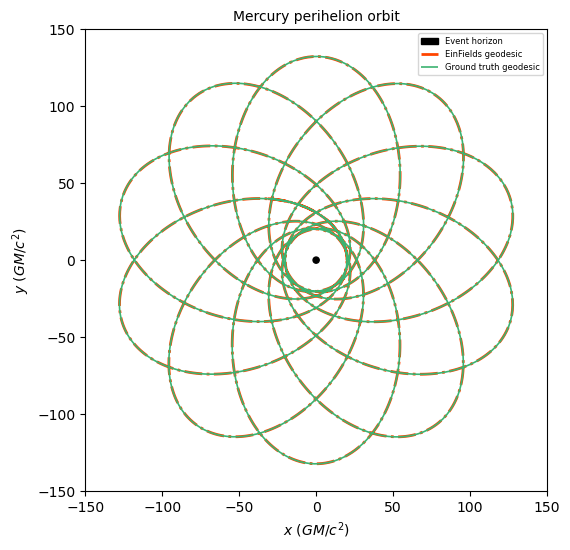

In [13]:
create_plot(150, 150, 
            config = {
        "name" : "Schwarzschild",
        "M" : 1.0,
        "a" : 0.0,
    },
    orbit_name = "Mercury perihelion orbit",
    x_gt=trajectories_cartesian[..., 1],
    y_gt=trajectories_cartesian[..., 2],
    x_nef=trajectories_cartesian_nef[..., 1],
    y_nef=trajectories_cartesian_nef[..., 2])

##### Slingshot orbit: $v_{0}=1.111$ and $r_{0}=5.6M$

In [ ]:
gt_metric = schwarzschild_metric
gt_metric_tensor = diffgeo(gt_metric)

solver_params = create_solver_params(
    t1=5e4
)

x0, v0 = schwarzschild_init_condition(r0=5.6, theta0=jnp.pi / 2, phi0=0., M = 1.0, v0=1.111 * jnp.sqrt((1 / 5.6) / (1 - 2 / 5.6)), vr0=0., v_theta0=0., v_phi0=0.)

init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

trajectories_spherical = run_geodesic(gt_metric_tensor, init_condition, solver_params)

# Vectorize first over the spherical coordinates at each timestep and then over the trajectories (if any)
trajectories_cartesian = jax.vmap(jax.vmap(spherical_to_cartesian))(trajectories_spherical)

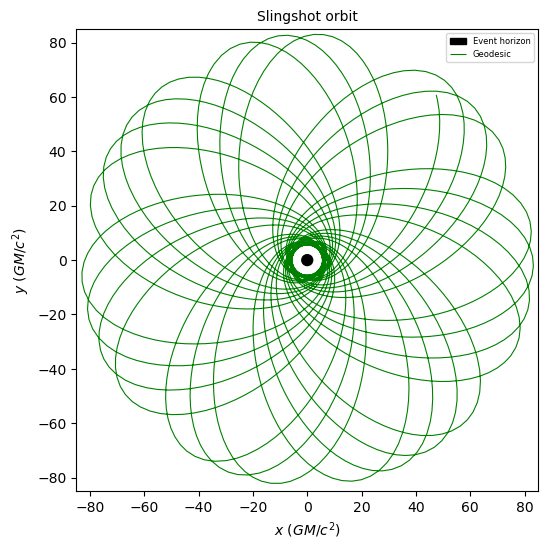

In [16]:
create_plot(85, 85, config = {
    "name" : "Schwarzschild",
    "M" : 1.0,
    "a" : 0.0,
}, orbit_name = "Slingshot orbit",
x_gt=trajectories_cartesian[..., 1],
y_gt=trajectories_cartesian[..., 2])

In [4]:
# directory of stored checkpoint
run_dir = os.path.abspath("../general_relativity/schwarzschild_geodesic_eccentric")
# unpack model and params
model, params_metric = get_model_and_params_checkpoint(run_dir)
 # note that this metric is only trained on the distortion part. Add spherical Minkowski metric as postprocessing step.
config = load_config(run_dir)

##### $v_{0} = 1.02$ and $r_{s}$ = $5M$ orbit

In [ ]:
gt_metric = schwarzschild_metric
nef_metric = lambda coords: model.apply(params_metric, coords).reshape(4, 4) + minkowski_metric_spherical(coords)
gt_metric_tensor = diffgeo(gt_metric)
nef_metric_tensor = diffgeo(nef_metric)

solver_params = create_solver_params(
    t1=5e3
)

x0, v0 = schwarzschild_init_condition(r0=5., theta0=jnp.pi / 2, phi0=0., M = 1.0, v0=1.02 * jnp.sqrt((1 / 5.) / (1 - 2 / 5.)), vr0=0., v_theta0=0., v_phi0=0.)

init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

trajectories_spherical = run_geodesic(gt_metric_tensor, init_condition, solver_params)
trajectories_spherical_nef = run_geodesic(nef_metric_tensor, init_condition, solver_params, coord_transform=modified_coords_nef)

trajectories_cartesian = jax.vmap(jax.vmap(spherical_to_cartesian))(trajectories_spherical)
trajectories_cartesian_nef = jax.vmap(jax.vmap(spherical_to_cartesian))(trajectories_spherical_nef)

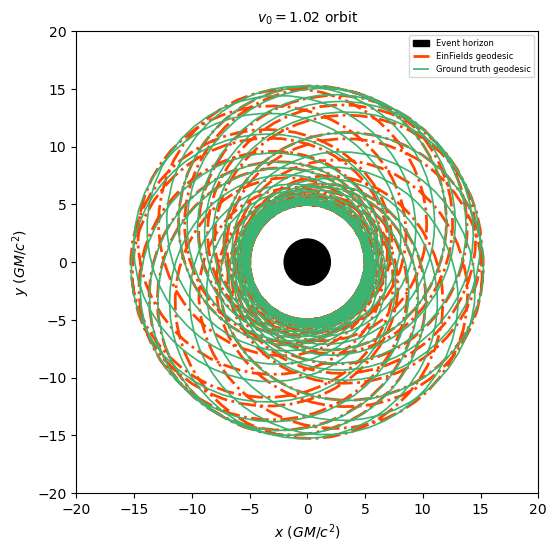

In [31]:
create_plot(20, 20,
            config = {
        "name" : "Schwarzschild",
        "M" : 1.0,
        "a" : 0.0,
    },
    orbit_name = "$v_{0}=1.02$ orbit",
    x_gt=trajectories_cartesian[..., 1],
    y_gt=trajectories_cartesian[..., 2],
    x_nef=trajectories_cartesian_nef[..., 1],
    y_nef=trajectories_cartesian_nef[..., 2])

##### 7. Coordinate invariant quantities and change of coordinates

We'll start by introducing the Schwarzschild metric in two other coordinates, the Kerr-Schild and Eddington-Finkelstein representations.
$$g^{Kerr-Schild}_{\mu\nu} = \begin{pmatrix}
-(1-\frac{2M}{r}) & \frac{2Mx}{r^2} & \frac{2My}{r^2} &  \frac{2Mz}{r^2} \\
\frac{2Mx}{r^2} & 1 + \frac{2Mx^2}{r^3} & \frac{2Mxy}{r^3} & \frac{2Mxz}{r^3} \\
\frac{2My}{r^2} & \frac{2Mxy}{r^3} & 1 + \frac{2My^2}{r^3} & \frac{2Myz}{r^3} \\
\frac{2Mz}{r^2} & \frac{2Mxz}{r^3} & \frac{2Myz}{r^3} & 1 + \frac{2Mz^2}{r^3}
\end{pmatrix}$$
$$g^{Eddington-Finkelstein}_{\mu\nu} = \begin{pmatrix}
-(1-\frac{2M}{r}) & 1 & 0 &  0 \\
1 & 0 & 0 & 0 \\
0 & 0 & r^2 & 0 \\
0 & 0 & 0 & r^2sin^2\theta
\end{pmatrix}$$
The coordinates in Kerr-Schild are $(t, x, y, x)$ and in Eddington-Finkelstein are $(v, r, \theta, \phi)$, where in both cases $r=\sqrt{x^2+y^2+z^2}$ is the usual radial coordinate and $v=t+r + 2M\ln|\frac{r}{2M} - 1|$. So, Kerr-Schild is a cartesian-like representation of Schwarzschild and Eddington-Finkelstein is spherical-like with a new "time" coordinate mixed with the radial part.

Note also from the representations in these coordinates that no metric component blows-up to infinity at any of the points in the coordinate domain apart from $r=0$. In contrast, the Schwarzschild metric in spherical coordinates is singular when $r=2M$ or by the usual name, when $r$ is at the event horizon.

In [13]:
schwarzschild_kerr_schild = lambda coords: schwarzschild_metric_kerr_schild(coords, M=1.0)
schwarzschild_eddington = lambda coords: schwarzschild_metric_eddington_finkelstein(coords, M=1.0)

Scalars are coordinate invariant. In principle we can say any quantity is coordinate invariant, vectors and tensors as well because the mathematics of manifolds was meant to be defined by objects and how they act on other objects with no mention of coordinates whatsoever. 

In practice, we are not working with these abstract objects, but we pick a coordinate system and they have a coordinate representation. A vector or the expression $V^\mu\partial_{\mu}$ is an invariant, it is the same object in all cordinates, but for this to happen their coordinate representation $V^\mu$ or $\partial_{\mu}$ must change. Hence, we will just say scalars are coordinate invariant because we will work all the time with a coordinate representation of a tensor.

Among all scalars in general relativity, three are very important and they appear most often:
- The Ricci scalar $R=R^{\mu}_{\mu}$.
- The Kretschmann scalar $K=R_{abcd}R^{abcd}$, where $R_{abcd}$ is the Riemann tensor with all indices down.
- The Weyl invariant $I_{1}=C_{abcd}C^{abcd}$, where $C_{abcd}$ is the Weyl tensor.

Concretely, the Ricci scalar is a measure of volume distortion compared to Euclidean space. The Kretschmann is a measure of curvature strength and because is an invariant it detects only the 
"true" singularities (or regions of infinite $K$) while some coordinates might have additional
"fake" singularities. The Weyl invariant is a measure of the shape distortion compared to Euclidean space. Mathematically, the Weyl invariant is formed by "squaring" the Weyl tensor which is the Riemann tensor from which Ricci tensor components and Ricci scalar are subtracted making a trace-free tensor.

Lets start by looking at the change of coordinates. The metric tensor transforms by a double contraction with the Jacobian of the coordinate transformation $x' = f(x)$ for some function f.
$$g'_{\mu\nu}(x') = \frac{\partial x^{\rho}}{\partial x'^{\mu}}\frac{\partial x^{\sigma}}{\partial x'^{\nu}}g_{\rho\sigma}(x)$$

In [14]:
spherical_coords = jnp.array([0, 3, jnp.pi / 2, 0]) # Pick a spherical coordinate point
# The 'DifferentialGeometry' class can also handle coordinate transformations of arbitrary tensors.
# For example, we can transform the metric tensor from spherical coordinates to Eddington coordinates.
from general_relativity import spherical_to_ingoing_eddington_finkelstein
spherical_to_eddington_coord_transform = lambda coords: spherical_to_ingoing_eddington_finkelstein(coords, M=1.0)
eddington_from_spherical = diffgeo.tensor_frame_transformation(coord_transform=spherical_to_eddington_coord_transform,
                                                               tensor=schwarzschild_metric,
                                                               rank=(0, 0), # Specify the rank, for the metric is double covariant so (0, 0)
                                                               coords=spherical_coords)


print(f"Spherical coordinates: {spherical_coords}\n")
print(f"Metric tensor in spherical coordinates:\n{schwarzschild_metric(spherical_coords)}\n")
print(f"Metric tensor in Eddington-Finkelstein coordinates :\n{eddington_from_spherical}\n")
print(f"Analyitical Eddington-Finkelstein metric :\n{schwarzschild_eddington(spherical_to_eddington_coord_transform(spherical_coords))}\n")

Spherical coordinates: [0.   3.   1.57 0.  ]

Metric tensor in spherical coordinates:
[[-0.33  0.    0.    0.  ]
 [ 0.    3.    0.    0.  ]
 [ 0.    0.    9.    0.  ]
 [ 0.    0.    0.    9.  ]]

Metric tensor in Eddington-Finkelstein coordinates :
[[-3.33e-01  1.00e+00  0.00e+00  0.00e+00]
 [ 1.00e+00  4.77e-07  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  9.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  9.00e+00]]

Analyitical Eddington-Finkelstein metric :
[[-0.33  1.    0.    0.  ]
 [ 1.    0.    0.    0.  ]
 [ 0.    0.    9.    0.  ]
 [ 0.    0.    0.    9.  ]]



Don't get confused by the appearance of Boyer-Lindquist coordinate system, it is a special type of oblate spheroidal coordinates which are the same as spherical for non-rotating black holes or when the spin parameter $a=0$. 

In [15]:
from gr_package.gr_problems.utils_coord_transforms import boyer_lindquist_to_kerr_schild
spherical_to_kerr_schild_coord_transform = lambda coords: boyer_lindquist_to_kerr_schild(coords, M=1.0, a=0.)
spherical_from_kerr_schild = diffgeo.tensor_frame_transformation(coord_transform=spherical_to_kerr_schild_coord_transform,
                                                          tensor=schwarzschild_metric,
                                                          rank=(0, 0), # For the metric is double covariant so (0, 0)
                                                          coords=spherical_coords)
print(f"Spherical coordinates: {spherical_coords}\n")
print(f"Metric tensor in spherical coordinates:\n{schwarzschild_metric(spherical_coords)}\n")
print(f"Metric tensor in Kerr-Schild coordinates :\n{spherical_from_kerr_schild}\n")
print(f"Analytical Kerr-Schild metric :\n{schwarzschild_kerr_schild(spherical_to_kerr_schild_coord_transform(spherical_coords))}\n")


Spherical coordinates: [0.   3.   1.57 0.  ]

Metric tensor in spherical coordinates:
[[-0.33  0.    0.    0.  ]
 [ 0.    3.    0.    0.  ]
 [ 0.    0.    9.    0.  ]
 [ 0.    0.    0.    9.  ]]

Metric tensor in Kerr-Schild coordinates :
[[-3.33e-01  6.67e-01  0.00e+00 -2.91e-08]
 [ 6.67e-01  1.67e+00  0.00e+00 -2.91e-08]
 [ 0.00e+00  0.00e+00  1.00e+00  0.00e+00]
 [-2.91e-08 -2.91e-08  0.00e+00  1.00e+00]]

Analytical Kerr-Schild metric :
[[-3.33e-01  6.67e-01  0.00e+00 -2.91e-08]
 [ 6.67e-01  1.67e+00  0.00e+00 -2.91e-08]
 [ 0.00e+00  0.00e+00  1.00e+00 -0.00e+00]
 [-2.91e-08 -2.91e-08 -0.00e+00  1.00e+00]]



Now, lets turn our attention to the three scalars and check their invariance.

In [16]:
schwarzs_kerr_schild_geo = diffgeo(metric=schwarzschild_kerr_schild)
schwarzs_eddington_geo = diffgeo(metric=schwarzschild_eddington)

print(f"Ricci, Kretschmann and Weyl invariant scalars for Schwarzschild in spherical coordinates:\n")
print(f"Ricci scalar: {schwarzschild_geo.ricci_scalar(spherical_coords):0.2e}")
print(f"Kretschmann scalar: {schwarzschild_geo.kretschmann_invariant(spherical_coords):0.2e}")
print(f"Weyl invariant scalar: {schwarzschild_geo.first_invariant_weyl(spherical_coords):0.2e}\n")

print(f"Ricci, Kretschmann and Weyl invariant scalars for Schwarzschild in Kerr-Schild coordinates:\n")
print(f"Ricci scalar: {schwarzs_kerr_schild_geo.ricci_scalar(spherical_to_kerr_schild_coord_transform(spherical_coords)):0.2e}")
print(f"Kretschmann scalar: {schwarzs_kerr_schild_geo.kretschmann_invariant(spherical_to_kerr_schild_coord_transform(spherical_coords)):0.2e}")  
print(f"Weyl invariant scalar: {schwarzs_kerr_schild_geo.first_invariant_weyl(spherical_to_kerr_schild_coord_transform(spherical_coords)):0.2e}\n")

print(f"Ricci, Kretschmann and Weyl invariant scalars for Schwarzschild in Eddington-Finkelstein coordinates:\n")
print(f"Ricci scalar: {schwarzs_eddington_geo.ricci_scalar(spherical_to_eddington_coord_transform(spherical_coords)):0.2e}")
print(f"Kretschmann scalar: {schwarzs_eddington_geo.kretschmann_invariant(spherical_to_eddington_coord_transform(spherical_coords)):0.2e}")
print(f"Weyl invariant scalar: {schwarzs_eddington_geo.first_invariant_weyl(spherical_to_eddington_coord_transform(spherical_coords)):0.2e}\n")

Ricci, Kretschmann and Weyl invariant scalars for Schwarzschild in spherical coordinates:

Ricci scalar: 2.38e-08
Kretschmann scalar: 6.58e-02
Weyl invariant scalar: 6.58e-02

Ricci, Kretschmann and Weyl invariant scalars for Schwarzschild in Kerr-Schild coordinates:

Ricci scalar: 1.24e-08
Kretschmann scalar: 6.58e-02
Weyl invariant scalar: 6.58e-02

Ricci, Kretschmann and Weyl invariant scalars for Schwarzschild in Eddington-Finkelstein coordinates:

Ricci scalar: 8.28e-09
Kretschmann scalar: 6.58e-02
Weyl invariant scalar: 6.58e-02



Apart from the Ricci scalar which is esentially zero, but its limited by the precision of float32 we can clearly observe how all scalars are equal. For vaccum solutions as Schwarzschild the Ricci tensor and Ricci scalar being zero makes the Weyl tensor equal to the Riemann tensor and therefore the Kretschmann and Weyl invariant scalars are the same.

##### 8. Levi-Civita connection (covariant derivative) and the Lie derivative

A simple example is the covariant derivative $\nabla_{i} v^{j}$ for the vector $\bold{v}=\begin{pmatrix}
1-\frac{2M}{r}, & 0, & 0, & 0 \\
\end{pmatrix}.$

The analytic result is
$$\nabla_{i} v^{j}=\begin{pmatrix}
0 & \frac{M}{r^2}(1-\frac{2M}{r})^2 & 0 & 0 \\
\frac{3M}{r^2} & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 
\end{pmatrix}.$$

In [17]:
# Assuming M = 1
coords_spherical = jnp.array([0, 3, jnp.pi / 2, 0])  # Example spherical coordinates where to evaluate the covariant derivative
vector = lambda coords: jnp.array([1 - 2 / coords[1], 0, 0, 0]) # Example vector field in Schwarzschild coordinates
def analytical_covariant_derivative(coords):
    t, r, theta, phi = coords
    return jnp.array([[0, 1 / r**2 * (1 - 2 / r)**2, 0, 0],
                      [3 / r**2, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]]) 

print(f"The coordinates where to evaluate the covariant derivative: {coords_spherical}\n")
print(f"The covariant derivative of the vector field is:")
print(schwarzschild_geo.levi_civita_connection(coords_spherical, vector, rank=(1,)))  # rank=(1,) for a vector field (contravariant tensor)
print(f"\nThe analytical covariant derivative of the vector field is")
print(analytical_covariant_derivative(coords_spherical))  # The analytical covariant derivative of the vector field

The coordinates where to evaluate the covariant derivative: [0.   3.   1.57 0.  ]

The covariant derivative of the vector field is:
[[0.   0.01 0.   0.  ]
 [0.33 0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]

The analytical covariant derivative of the vector field is
[[0.   0.01 0.   0.  ]
 [0.33 0.   0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]


Compared to the Levi-Civita connection, the Lie derivative is independent of a connection, but if a connection is given and is torsion-free such as the Levi-Civita, then the Lie derivative is unchanged.

A canonical test is to see in action some of the Killing vector fields of the Schwarzschild metric, which are translations in time and rotations. Lets pick the time translation and the $L_{(1)}$ rotation:
$$
    L_{(0)} = \frac{\partial}{\partial t}
$$
$$
    L_{(1)} = -\sin\phi\frac{\partial}{\partial \theta} -\cot\theta \cos\phi\frac{\partial}{\partial \phi}.
$$

Then, the Killing equation reads
$$
    \mathcal{L}_{L}g_{\mu\nu} = 0,
$$

where $L$ can be any of the symmetries above. For the time vector field its clear the directional-derivative its zero because Schwarzschild is time-independent.

In [18]:
coords_spherical = jnp.array([0, 3, jnp.pi / 4, 0.3])  # Example spherical coordinates where to evaluate the Lie derivative
time_vector = lambda coords: jnp.array([1, 0, 0, 0])  # Time-like vector field in shperical coordinates
l1_vector = lambda coords: jnp.array([0., 0., -jnp.sin(coords[3]), -1 / jnp.tan(coords[2]) * jnp.cos(coords[3])])  # L1 vector field in spherical coordinates

lie_derivative_time = diffgeo.lie_derivative(coords=coords_spherical, 
                                             vector_field=time_vector, 
                                             tensor=schwarzschild_metric,
                                             rank=(0, 0))  # rank=(0, 0) for the metric tensor, double covariant

lie_derivative_l1 = diffgeo.lie_derivative(coords=coords_spherical,
                                             vector_field=l1_vector,
                                             tensor=schwarzschild_metric,
                                             rank=(0, 0))  # rank=(0, 0) for the metric tensor, double covariant

print(f"Spherical coordinates: {coords_spherical}\n")
print(f"Lie derivative of the metric tensor with respect to the time vector field:\n{lie_derivative_time}\n")
print(f"Lie derivative of the metric tensor with respect to the L1 vector field:\n{lie_derivative_l1}\n")

Spherical coordinates: [0.   3.   0.79 0.3 ]

Lie derivative of the metric tensor with respect to the time vector field:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Lie derivative of the metric tensor with respect to the L1 vector field:
[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -9.54e-07]
 [ 0.00e+00  0.00e+00 -9.54e-07  0.00e+00]]



If jitting functions like the `levi-civita_connection` or `lie_derivative` most probably you will do this after vmapping over `coords` to handle batches as the other are merely static arguments. In this case it makes it easier if you close the function into one depending only on `coords`. Otherwise you need to tell jit what are the static arguments (or it might do it by default as tuples are considered static by default). When you close functions like below jit will trace its inner definition in a "linear" fashion, if a for loop has an if inside that depends only on the static arguments (everything other than `coords` in this case), then these values are evaluated and the compiler stores only the True or the False part of the conditional.

In [19]:
lie_derivative = lambda coords: diffgeo.lie_derivative(coords=coords,
                                                     vector_field=l1_vector,
                                                     tensor=schwarzschild_metric,
                                                     rank=(0, 0))

lie_derivative_jitt = jax.jit(lie_derivative)

print(lie_derivative(coords_spherical))

[[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00 -9.54e-07]
 [ 0.00e+00  0.00e+00 -9.54e-07  0.00e+00]]


##### 9. How jax.jit improves the performance

Lets test with the Schwarzschild metric in Kerr-Schild coordinates in which all entries are non-zero. The quantity of interest for this benchmark is the Ricci scalar as it represents the last thing in the long chain of differentiations and contractions required to get to it. The numbers are showed on a Macbook Pro with M1 chip CPU. For a GPU or other CPUs the results will be different. They also depend on the batch size chosen with the differences being more pronounced for smaller batches.

In [20]:
import time

In [21]:
schwarzs_kerr_schild_vdg = vdiffgeo(diffgeo(schwarzschild_kerr_schild))

batch_coords_kerr_schild = jax.random.uniform(jax.random.PRNGKey(0), shape=(100000, 4), minval=0.5, maxval=3)

jitted_version = jax.jit(schwarzs_kerr_schild_vdg.ricci_scalar)
non_jitted_version = schwarzs_kerr_schild_vdg.ricci_scalar
time1 = []
time2 = []

test1 = jitted_version(batch_coords_kerr_schild)
test2 = non_jitted_version(batch_coords_kerr_schild)

for _ in range(100):
    start_time = time.time()
    metric_tensor_batch = non_jitted_version(batch_coords_kerr_schild).block_until_ready()
    end_time = time.time()
    # print(f"Iteration {_+1}: Non Jitted tensor computed in {end_time - start_time:.6f} seconds")
    time1.append(end_time - start_time)
    start_time = time.time()
    metric_tensor_batch = jitted_version(batch_coords_kerr_schild).block_until_ready()
    end_time = time.time()
    time2.append(end_time - start_time)
    # print(f"Iteration {_+1}: Jitted tensor computed in {end_time - start_time:.6f} seconds\n")

avg_time1 = jnp.mean(jnp.array(time1))
avg_time2 = jnp.mean(jnp.array(time2))
print(f"Average time for non-jitted: {avg_time1:.6f} seconds")
print(f"Average time for jitted: {avg_time2:.6f} seconds")

print(f"Speedup factor on average for 1e5 batch size: {avg_time1 / avg_time2:.2f}")

Average time for non-jitted: 0.807107 seconds
Average time for jitted: 0.314501 seconds
Speedup factor on average for 1e5 batch size: 2.57


##### 10. Tetrads

Tetrads are simply matrices, diagonalising the metric tensor in the (-, +, +, +) signature (depending on convetion) of the Minkowski metric. In other words, it gives an orthonormal flat space basis locally at each point in spacetime. There are plenty of examples, but you could see this for the Schwarzschild metric which is diagonal, so basis vectors are orthogonal, but not of unit norm. These vectors are either streched or shrunk depending on the curvature or coordinate system artifacts. The $\theta$ and $\phi$ directions have the spherical $r^2$ term representing physical changes to account for different distances when rotating in circles of various radii.

Therefore, tetrads are very useful in choosing initial conditions for ray tracing in spacetime or simply to draw geodesics. Lets have a look at an observer at $r=12$, $\theta=\pi/2$ and $\phi=0$ (as usual in G=c=1 units). You might want to choose some velocity initial conditions $v^{\mu}$ going out radially from the observer. For doing this you can for example choose $v^{r}=\cos\alpha$ and $v^{\phi}=\sin\alpha$ for the components. Assuming your basis is orthonormal you would think this is exactly what is needed.

In our code, the diagonalization creates the tetrad $e_{\mu}^{i}$ which is to transform spacetime vector components to the local flat basis, but instead here we need its inverse or $e_{i}^{\mu}$=$(e_{\mu}^{i})^{-1}$.

Tetrad evaluated at [ 0.   12.    1.57  0.  ]:
[[ 9.13e-01  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  1.10e+00  3.58e-07  1.01e-07]
 [ 0.00e+00  2.61e-09 -7.63e+00 -9.26e+00]
 [ 0.00e+00  7.19e-09 -9.26e+00  7.63e+00]]



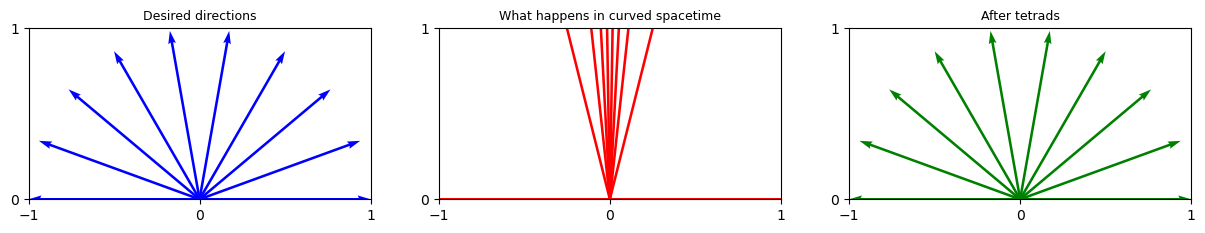

In [22]:
alpha = jnp.linspace(0, jnp.pi, 10)
velocity = jnp.array([jnp.zeros_like(alpha), jnp.cos(alpha), jnp.zeros_like(alpha), jnp.sin(alpha)])  # 4-velocity in spherical coordinates
coords = jnp.array([0., 12., jnp.pi / 2, 0.])  # Example coordinates where to evaluate the tetrad
schwarzschild_metric_eval = schwarzschild_metric(coords)

tetrad_eval = schwarzschild_geo.tetrad(coords)
tetrad_eval_inv = jnp.linalg.inv(tetrad_eval)
print(f"Tetrad evaluated at {coords}:\n{tetrad_eval}\n")

# The tetrad construction uses a numerical eigendecomposition of the metric tensor,
# which doesn't guarantee the tetrad is diagonal although the metric admits a diagonal tetrad.
# This can be seen when printing tetrad_eval_inv, the 3'rd and 4'th columns are not alligned 
# with the standard coordinate basis. The vectors are just rotated, so we can simply take their norms
# and set the corresponding columns with the modified magnitude.
norm_theta = jnp.sqrt(jnp.sum(jnp.square(tetrad_eval_inv[:, 2])))
norm_phi = jnp.sqrt(jnp.sum(jnp.square(tetrad_eval_inv[:, 3]))) 
tetrad_eval_inv = tetrad_eval_inv.at[:, 2].set(jnp.array([0., 0., 1., 0.]) * norm_theta)
tetrad_eval_inv = tetrad_eval_inv.at[:, 3].set(jnp.array([0., 0., 0., 1.]) * norm_phi)  # Set the theta and phi components to zero

schwarzschild_eval_alpha = jnp.tile(schwarzschild_metric_eval.reshape(4, 4, 1), (1, 1, len(alpha)))  # Repeat the metric for each alpha value
tetrad_eval_inv = jnp.tile(tetrad_eval_inv.reshape(4, 4, 1), (1, 1, len(alpha)))  # Repeat the tetrad for each alpha value
tetrad_velocity_coordinates = jnp.einsum('ijk, ik -> jk', tetrad_eval_inv, velocity)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].quiver(jnp.zeros_like(velocity[0]), 
               jnp.zeros_like(velocity[0]), 
               velocity[1], 
               velocity[3], 
               angles='xy', scale_units='xy', scale=1, color='blue')
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(0, 1)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_title('Desired directions', fontsize=9)
axes[0].set_xticks([-1., 0., 1.])
axes[0].set_yticks([0., 1.])
axes[1].quiver(
    jnp.zeros_like(velocity[0]), 
    jnp.zeros_like(velocity[0]), 
    velocity[1] * jnp.sqrt(schwarzschild_metric_eval[1, 1]),
    velocity[3] * jnp.sqrt(schwarzschild_metric_eval[3, 3]), 
    angles='xy', scale_units='xy', scale=1, color='red')
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(0, 1)
axes[1].set_aspect('equal', adjustable='box')
axes[1].set_title('What happens in curved spacetime', fontsize=9)
axes[1].set_xticks([-1., 0., 1.])
axes[1].set_yticks([0., 1.])
axes[2].quiver(
    jnp.zeros_like(tetrad_velocity_coordinates[0]), 
    jnp.zeros_like(tetrad_velocity_coordinates[0]), 
    tetrad_velocity_coordinates[1] * jnp.sqrt(schwarzschild_metric_eval[1, 1]), 
    tetrad_velocity_coordinates[3] * jnp.sqrt(schwarzschild_metric_eval[3, 3]), 
    angles='xy', scale_units='xy', scale=1, color='green')
axes[2].set_xlim(-1, 1)
axes[2].set_ylim(0, 1)
axes[2].set_aspect('equal', adjustable='box')
axes[2].set_title('After tetrads', fontsize=9)
axes[2].set_xticks([-1., 0., 1.])
axes[2].set_yticks([0., 1.])
plt.show()

## Kerr metric

Similar aspects can be discussed with regard to the Kerr metric, but nothing new to what you have seen already up to this point. The Kerr metric is usually expressed in Boyer-Lindquist coordinates, this has the disadvantage of having an inner and outer horizons, or fake singularities that can be removed by a change of coordinates. Such an example is the Kerr-Schild coordinates which we saw before in the case of a non-rotating black hole. In this representation only one singularity remains called the ring singularity which is at $x^2+y^2=a^2$ and $z=0$ in cartesian or Kerr-Schild $(t,x,y,z)$. We can have a clear look to probe this by visualising the curvature strength near $z=0$, in other words analysing the Kretschmann scalar in the region.

##### 1. Kretschmann

In [23]:
from general_relativity.metrics.kerr import kerr_schild_cartesian_metric

In [24]:
t = jnp.array([0])
x = jnp.linspace(-3., 3., 128)
y = jnp.linspace(-3., 3., 128)
z = jnp.linspace(0.1, 3., 128)
t, x, y, z = jnp.meshgrid(t, x, y, z, indexing='ij')
# Stack the coordinates into a single array
batch_coords = jnp.stack([t, x, y, z], axis=-1).reshape(-1, 4)
print(f"Shape of the coordinates array: {batch_coords.shape}")

Shape of the coordinates array: (2097152, 4)


In [25]:
kerr_schild = lambda coords: kerr_schild_cartesian_metric(coords, M=1.0, a=0.7)
kerr_schild_vdg = vdiffgeo(diffgeo(kerr_schild))

kretschmann_invariant = kerr_schild_vdg.kretschmann_invariant(batch_coords)

In [26]:
def slice_grid_coords(input, i, axis):
    """Extract the 2D plane from the coordinates on the 3D grid at the specified index i along the axis."""
    assert axis in [0,1,2], "axis must be one of 0,1,2"
    # assert 0<=i<input.shape[axis], "index out of bounds"
    if axis==0:
        return input[i,:,:][...,[1,2]]
    if axis==1:
        return input[:,i,:][...,[0,2]]
    if axis==2:
        return input[:,:,i][...,[0,1]]

def slice_grid(input, i, axis):
    """Extract the 2D plane from the metric on the 3D grid."""
    assert axis in [0,1,2], "axis must be one of 0,1,2"
    if axis==0:
        return input[i,:,:]
    if axis==1:
        return input[:,i,:]
    if axis==2:
        return input[:,:,i]
    
plane_axis = 2 #2
plane_i = 0 # 40
coords_sliced = slice_grid_coords(batch_coords[:, 1:].reshape(128, 128, 128, 3), plane_i, plane_axis)

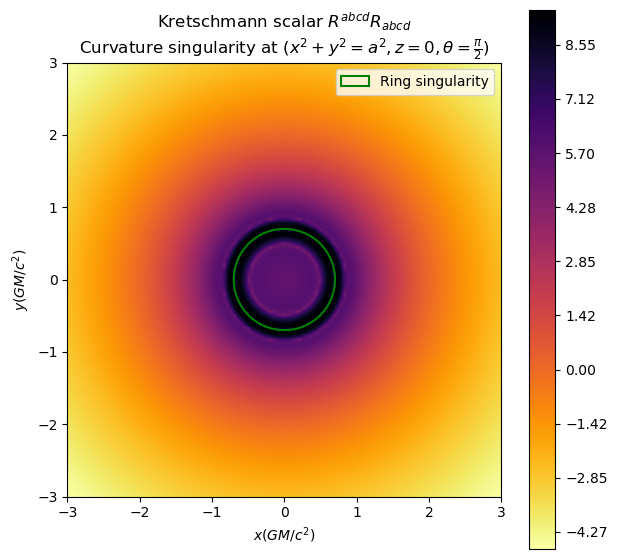

In [27]:
kretschmann_slice = slice_grid(kretschmann_invariant.reshape(128, 128, 128), plane_i, plane_axis)

plt.figure(figsize=(7, 7))
cs = plt.contourf(
    coords_sliced[:,:,0], 
    coords_sliced[:,:,1], 
    jnp.log(jnp.abs(kretschmann_slice)),
    levels=1000, 
    cmap="inferno_r")

# Spectral_r
# plt.contour(XY[:,:,0], XY[:,:,1], jnp.log(jnp.abs(kretschmann_scalar_sliced)), levels=50, colors='g', linewidths=0.4, negative_linestyles='solid')
cbar =  plt.colorbar(cs)
center_x, center_y = 0, 0  # Center of the circle
M = 1.0


ring_singularity = plt.Circle((center_x, center_y), 0.7, color='g', fill=False, linestyle='-', linewidth=1.5, label='Ring singularity')
# Add the circle to the plot
plt.gca().add_artist(ring_singularity)

plt.legend()
plt.axis('scaled')
plt.title(r"Kretschmann scalar $R^{abcd} R_{abcd}$" + "\n" +  r"Curvature singularity at $(x^2 + y^2 = a^2, z = 0, \theta = \frac{\pi}{2})$", fontsize=12)
plt.xlabel(r"$x(GM/c^2)$")
plt.ylabel(r"$y(GM/c^2)$")
plt.show()

##### 2. Geodesics

In [9]:
from general_relativity.metrics.kerr import kerr_metric_boyer_lindquist
from general_relativity import oblate_spheroid_to_cartesian
from general_relativity.geodesics.utils_geodesics import kerr_init_condition

#### Zackiger orbit

In [ ]:
gt_metric = lambda coords: kerr_metric_boyer_lindquist(coords, M=1.0, a=0.95)
gt_metric_tensor = diffgeo(gt_metric)

solver_params = create_solver_params(
    t1=1641,
)

x0, v0 = kerr_init_condition(r0=6.5, theta0=jnp.pi / 2, phi0=0., M = 1.0, a=0.95, L_z=-0.830327, v0=0.5, vr0=0., v_theta0=-jnp.cos(11 / 50) / 2)

init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

trajectories_boyer_lindquist = run_geodesic(gt_metric_tensor, init_condition, solver_params)

trajectories_cartesian_gt = jax.vmap(jax.vmap(oblate_spheroid_to_cartesian, in_axes=[0, None]), in_axes=[0, None])(trajectories_boyer_lindquist, 0.95)

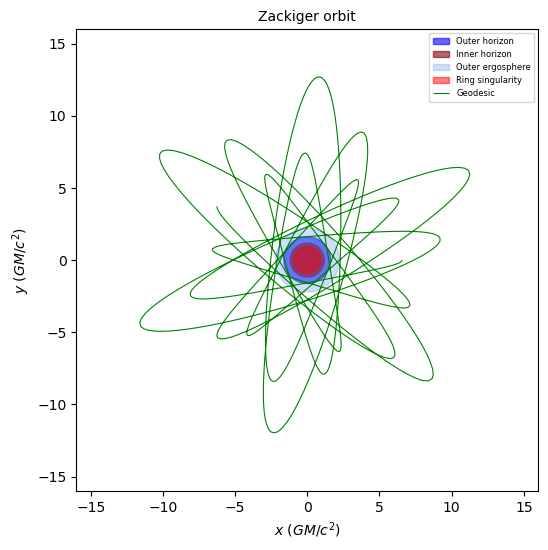

In [66]:
create_plot(16, 16,
            config={
                "name" : "Kerr",
                "M" : 1.0,
                "a" : 0.95},
            orbit_name='Zackiger orbit',
            x_gt=trajectories_cartesian_gt[..., 1],
            y_gt=trajectories_cartesian_gt[..., 2])

#### Prograde orbit

In [ ]:
gt_metric = lambda coords: kerr_metric_boyer_lindquist(coords, M=1.0, a=0.9)
gt_metric_tensor = diffgeo(gt_metric)

solver_params = create_solver_params(
    t1=933,
)

x0, v0 = kerr_init_condition(r0=7, theta0=jnp.pi / 2, phi0=0., M = 1.0, a=0.9, L_z=1.97647, v0=0.4, vr0=0., v_theta0=2.34695 * jnp.sqrt(1 - 0.4**2) / 7)

init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

trajectories_boyer_lindquist = run_geodesic(gt_metric_tensor, init_condition, solver_params)

trajectories_cartesian_gt = jax.vmap(jax.vmap(oblate_spheroid_to_cartesian, in_axes=[0, None]), in_axes=[0, None])(trajectories_boyer_lindquist, 0.9)

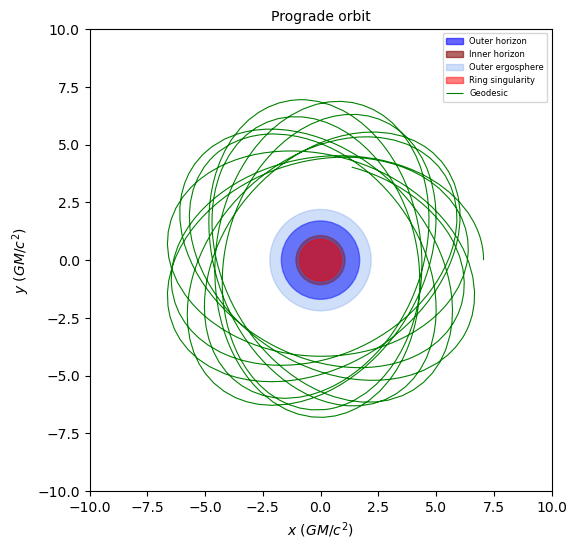

In [69]:
create_plot(10, 10,
            config={
                "name" : "Kerr",
                "M" : 1.0,
                "a" : 0.9,
            },
            orbit_name="Prograde orbit",
            x_gt=trajectories_cartesian_gt[..., 1],
            y_gt=trajectories_cartesian_gt[..., 2])

#### Eccentric orbit a=0.628

In [ ]:
gt_metric = lambda coords: kerr_metric_boyer_lindquist(coords, M=1.0, a=0.628)
gt_metric_tensor = diffgeo(gt_metric)

solver_params = create_solver_params(
    t1=942,
    rtol=1e-8,
    atol=1e-9,
    max_steps=10000
)

x0, v0 = kerr_init_condition(r0=6.97177, theta0=jnp.pi / 2, phi0=0., M=1.0, a=0.628, L_z=1.95805, v0=0.4, vr0=0., v_theta0=2.33749 * jnp.sqrt(1 - 0.4**2) / 6.97177)

init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

trajectories_boyer_lindquist = run_geodesic(gt_metric_tensor, init_condition, solver_params)

trajectories_cartesian_gt = jax.vmap(jax.vmap(oblate_spheroid_to_cartesian, in_axes=[0, None]), in_axes=[0, None])(trajectories_boyer_lindquist, 0.628)

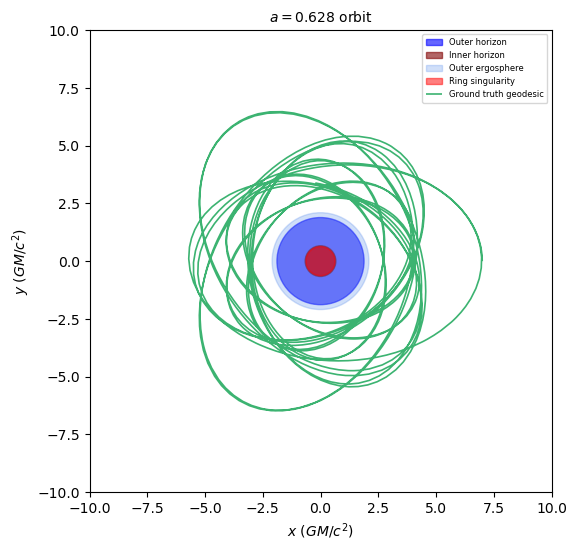

In [17]:
create_plot(10, 10,
            config={
                "name" : "Kerr",
                "M" : 1.0,
                "a" : 0.628,
            },
            orbit_name="$a=0.628$ orbit",
            x_gt=trajectories_cartesian_gt[..., 1],
            y_gt=trajectories_cartesian_gt[..., 2])

#### Eccentric orbit a=0.623

In [ ]:
gt_metric = lambda coords: kerr_metric_boyer_lindquist(coords, M=1.0, a=0.623)
gt_metric_tensor = diffgeo(gt_metric)

solver_params = create_solver_params(
    t1=905
)

x0, v0 = kerr_init_condition(r0=6.97222, theta0=jnp.pi / 2, phi0=0., M=1.0, a=0.623, L_z=1.95802, v0=0.4, vr0=0., v_theta0=2.33764 * jnp.sqrt(1 - 0.4**2) / 6.97222)

init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

trajectories_boyer_lindquist = run_geodesic(gt_metric_tensor, init_condition, solver_params)

trajectories_cartesian_gt = jax.vmap(jax.vmap(oblate_spheroid_to_cartesian, in_axes=[0, None]), in_axes=[0, None])(trajectories_boyer_lindquist, 0.623)

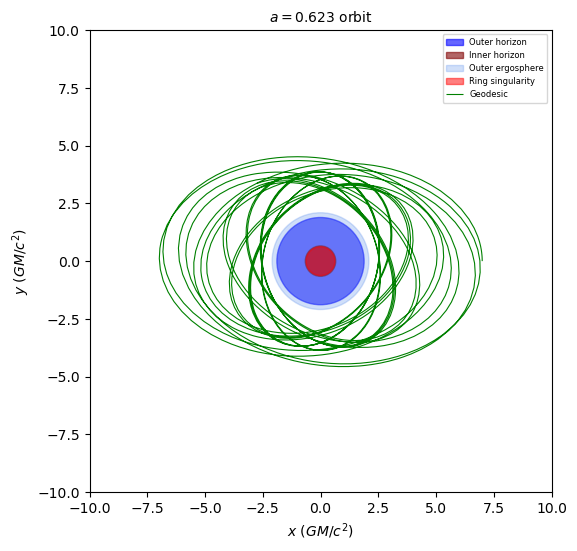

In [73]:
create_plot(10, 10,
            config={
                "name" : "Kerr",
                "M" : 1.0,
                "a" : 0.623,
            },
            orbit_name="$a=0.623$ orbit",
            x_gt=trajectories_cartesian_gt[..., 1],
            y_gt=trajectories_cartesian_gt[..., 2])

#### Eccentric orbit a=0.646

In [ ]:
gt_metric = lambda coords: kerr_metric_boyer_lindquist(coords, M=1.0, a=0.646)
gt_metric_tensor = diffgeo(gt_metric)

solver_params = create_solver_params(
    t1=976
)

x0, v0 = kerr_init_condition(r0=6.97013, theta0=jnp.pi / 2, phi0=0., M=1.0, a=0.646, L_z=1.95818, v0=0.4, vr0=0., v_theta0=2.33694 * jnp.sqrt(1 - 0.4**2) / 6.97013)

init_condition = jnp.concatenate([x0.reshape(1, -1), v0.reshape(1, -1)], axis=1)

trajectories_boyer_lindquist = run_geodesic(gt_metric_tensor, init_condition, solver_params)

trajectories_cartesian_gt = jax.vmap(jax.vmap(oblate_spheroid_to_cartesian, in_axes=[0, None]), in_axes=[0, None])(trajectories_boyer_lindquist, 0.646)

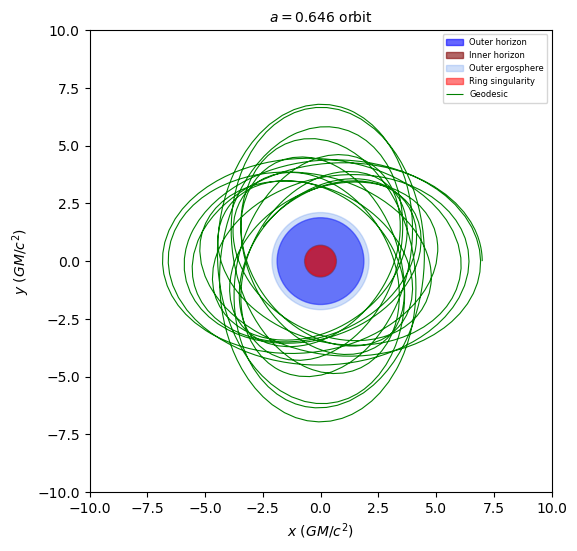

In [76]:
create_plot(10, 10,
            config={
                "name" : "Kerr",
                "M" : 1.0,
                "a" : 0.646,
            },
            orbit_name="$a=0.646$ orbit",
            x_gt=trajectories_cartesian_gt[..., 1],
            y_gt=trajectories_cartesian_gt[..., 2])